## Need to re do errors as used the full dataset in the erros I have but only useing 0.8 of the dataset in the testing


Using p vals to find error in true values. Then use bootstraping to find errors in predicted values. 
If errors overlap can say that the predction is correct? 

In [1]:
#imports and maths funcs used
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import scipy
from scipy import special
import time
from sklearn.metrics import mean_squared_error
#func to find the cosine similarity  vectors a and maxtrix B 
#where B is made up of vectors b1 b2... that are the same dim as a
#shape of B needs to be (a.shape,number of vectors to compare with)
import numpy.linalg as LA
def multi_cos_sim(a,B):
    #first to do some checks to see inputs are the right shape
    B_shape = B.shape 
    if B_shape[0] == len(a):
        numerator = np.dot(a,B)
        B_norm = LA.norm(B, axis=0)
        a_norm = LA.norm(a)
        return (numerator)/(B_norm*a_norm) # dont take abs yet intreased in postive and negative cosine sim
    else:
        print('Error dim of vectors in B, ' + str(B_shape[0]) + ' do not match dim a ' + str(len(a)))
        pass

def main_cos_sim(dataframe): #method to find the cosine similairty between all pairs of sites in a clean phos dataframe   
    simList = []
    i = 0 
    #for loop to apply above method to data
    for c in dataframe.columns:
        #print(i,c)
        v1 = dataframe[c].to_numpy()
        V2 = dataframe.to_numpy() #turns the table to numpy array, taking out lables
        V2 = V2 #turns data in V2 to np.float64 data type, required to use LA.norm func
        cosSim = multi_cos_sim(v1,V2)
        simList.append((cosSim))
        i = i +1
    return simList

In [2]:
def pre_process(file_pathFC,file_pathErrorCS,file_path_pval,fp_drop_sites):
    #inputs data and rearanges it
    raw_data = pd.read_csv(file_pathFC, sep=',') #imports the data into a pandas dataframe
    raw_data = raw_data.T
    raw_data.columns = raw_data.iloc[0]
    raw_data = raw_data.drop(raw_data.index[0])
    data = raw_data
    
    #takes out 'absent' swaps 'down' to -10 'up' to 10 and 'no change' to 0
    #as erf(10) = 1, erf(-10) = -1 and erf(0) = 0
    clean_data = data.replace('absent',np.nan).dropna(axis='columns')
    del_sites = np.loadtxt(fp_drop_sites, delimiter=',',dtype = 'str')
    clean_data = clean_data.drop(del_sites,axis = 1)
    clean_data = clean_data.replace('no_change',np.nan).dropna(axis='columns')
    clean_data = clean_data.replace('down',-10)
    clean_data = clean_data.replace('up',10)
    clean_data = clean_data.astype(float)
    
    squashed_data = special.erf(clean_data)
    #read in the errors/pvals
    CS_errorEfc = pd.read_csv(file_pathErrorCS, sep=',') 
    CS_errorEfc.drop(columns = 'pst',inplace = True)
    CS_errorEfc.index = CS_errorEfc.columns     
    raw_pvals = pd.read_csv(file_path_pval, sep=',') #imports the data into a pandas dataframe
    raw_pvals = raw_pvals.T
    raw_pvals.columns = raw_pvals.iloc[0]
    raw_pvals = raw_pvals.drop(raw_pvals.index[0])
    raw_pvals = raw_pvals.replace('absent',np.nan).dropna(axis='columns')
    raw_pvals = raw_pvals.drop(del_sites,axis = 1)
    raw_pvals = raw_pvals.replace('no_change',np.nan).dropna(axis='columns')
    raw_pvals =raw_pvals.astype('float')
    print('should match:')
    print(raw_pvals.shape,clean_data.shape) 
    stdDF = raw_pvals*clean_data
    stdDF_erf = stdDF*np.exp(-clean_data**2)*(2/ (np.pi**0.5) )
    
    return squashed_data,CS_errorEfc,stdDF_erf

def run_CS_anyli(procssed_data,inds):  #DF gives the cos_sim between rows and column, note diag 1 as it compares the same sites
    #procssed_data_copy = procssed_data.copy(deep=True)
    lower_index,upper_index,train_indx = inds
    test_data = procssed_data[lower_index:upper_index]
    train_data = procssed_data.iloc[train_indx]

    PairSimList = main_cos_sim(train_data)  
    CS_data = pd.DataFrame(PairSimList,index = procssed_data.columns, columns= procssed_data.columns)
    np.fill_diagonal(CS_data.values,0) #fills diag with 0 i.e. the sites comapred with themself    
    return CS_data,train_data,test_data


In [3]:
#funs that only need to be run ones for mulitple models with differnt cos_sim 
file_pathFC,file_pathErrorCS = 'ctamdb_data_fcs_MCF7.csv','CS_error_Erf.csv' 
file_path_pval,fp_drop_sites = 'ctamdb_data_pvals_MCF7.csv','MCF7_remove_sites'

squashed_data,CS_errorEfc,StandardErr_rawData = pre_process(file_pathFC,file_pathErrorCS,
                                                            file_path_pval,fp_drop_sites)

should match:
(61, 11320) (61, 11320)


In [11]:
#used for cross valdation 
#usesing for test of cross prediction across cell lines 
lower_index,upper_index = 0,round(len(squashed_data)*0.2) 
train_indxL,train_indxU = np.arange(0,lower_index),np.arange(upper_index,len(squashed_data))
train_indx = np.concatenate( (train_indxL,train_indxU ) )
inds = lower_index,upper_index,train_indx
CS_dataEfcMCF7,train_dataMCF7,test_dataMCF7 = run_CS_anyli(squashed_data,inds)

In [4]:
def test(data,cosSimX,CS_data,SE_rawData): #test the model useing the tranning data or testing data
    #tests the model       
    data_copy = data.copy(deep=True)
    err_data_subset = SE_rawData.iloc[train_indx]
    #find the sites that will become unseen
    rand = np.random.rand(len(data),len(data.T))
    nan_col_list = []
    true_vals = []
    # work out a way to do this in one go, if runnning time too long. (should't take too long only 61 loop)
    for i,r in zip(range(0,len(data)),rand): 
        nan_cols = data.columns[(r>0.8)]
        true_vals.append(data.iloc[i][nan_cols])
        data_copy.iloc[i][nan_cols] = np.nan #sets these sites to NaN/unseen
        nan_col_list.append(nan_cols)
        
    #loops over the columbs for each treatment, and the index of the treatment in the test dataset 
    y_test = [] #final predcited values
    true_nonNan = []
    true_nonNanErr = []
    for treatment_ind,cols in enumerate(nan_col_list):
        row_PV = []
        Ttrue_nonNan = []
        Ttrue_nonNanErr = []
        for site in cols: #loops over the sites that need predicting
            try:
                sim_sites = cosSimX.loc[site].dropna().index #this is where the 'model/traning data is used'
                CS_sim_site = CS_data.loc[site][sim_sites].values #finds the CS of above sites for wighted mean
            except KeyError:
                predictedVal = np.nan 
                sim_sites = []
            #should be able to take this next line out? 
            if len(sim_sites) == 0: #if there is no simliar sites than we can't predict a value, so keep it as nan
                predictedVal = np.nan 
            else: #else use the values from the test dataset and the simliar sites to predict a value
                #uses the mean weighted by the cos sim of the sites
                predictedVal = np.mean(data_copy.iloc[treatment_ind][sim_sites].dropna())
                """
                if meanT == False:
                    SimSvals = data_copy.iloc[treatment_ind][sim_sites]
                    if len(SimSvals.dropna()) > 0:
                        predictedVal1 = np.mean(SimSvals)
                        mask = np.isnan(SimSvals) == False 
                        CS_sim_site = CS_sim_site[mask]
                        predictedVal = np.average(SimSvals.dropna(),weights=CS_sim_site)
                """
                if np.isnan(predictedVal) == True:
                    pass
                else:
                    nonNan_t = data[site][treatment_ind]
                    nonNan_t_err = err_data_subset[site][treatment_ind]
                    Ttrue_nonNan.append(nonNan_t)
                    Ttrue_nonNanErr.append(nonNan_t_err)
            row_PV.append(predictedVal)
        y_test.append(row_PV)
        true_nonNan.append(Ttrue_nonNan)
        true_nonNanErr.append(Ttrue_nonNanErr)

    return y_test,true_nonNan,true_nonNanErr

def Find_sim_sitesQ(CS_data,err_df,threshold):
    cos98temp = CS_data[CS_data > threshold].dropna(how = 'all')
    return cos98temp


def run_model(CS_data_train,err_df,test_data,SE_rawData,threshold):
    cosSimX = Find_sim_sitesQ(CS_data_train,err_df,threshold)
    y_test,true_nonNan,true_nonNanErr = test(test_data,cosSimX,CS_data_train,SE_rawData)
    testR = [y_test,true_nonNan,true_nonNanErr]
    return testR

def find_non_na_predicitons(testR):
    y_test,true_nonNan,true_NNErr = testR[0],testR[1],testR[2]
    true_vals =  [item for sublist in true_nonNan for item in sublist]
    true_vals = np.round(np.array(true_vals))
    coverage = []
    predicted_vals = []
    for v in y_test: # v, vector of values for a treatment
        coverage.append(1 - np.sum(np.isnan(v))/len(v))
        pv_temp = []
        for comp in v:
            if np.isnan(comp) == False:
                predicted_vals.append(comp)
    coverage = np.array(coverage)
    print('ave % of non nan predictions')
    mean_coverage = np.mean(coverage)
    print(mean_coverage)
    acc = np.sum(np.array(true_vals) == np.round(np.array(predicted_vals))) /len(predicted_vals)
    print(acc) #accuracy on testing data
    print('acc')
    print("------")
    return predicted_vals,true_vals,mean_coverage,acc


In [5]:
#old method stuff
def Find_sim_sites(CS_data,err_df,threshold):
    cos98temp = CS_data[CS_data - err_df*2.0 > threshold].dropna(how = 'all')
    #taking the NaNs out of the above list and pairing the correlated sites with each other
    FL = []
    for i,r in cos98temp.iterrows():
        #print(i)
        #print('****')
        #print(r.dropna())
        for ind,val in zip(r.dropna().index,r.dropna()):
            FL.append( (i,ind,val) )
    cosSim98_err_inf = pd.DataFrame(FL)
    #cosSim98fliped = pd.DataFrame({0: cosSim98_err_inf[1],1: cosSim98_err_inf[0],2:cosSim98_err_inf[2] })
    return cosSim98_err_inf
def run_modelO(CS_data_train,err_df,test_data,threshold):
    cosSimX = Find_sim_sites(CS_data_train,err_df,threshold)
    y_test, true_nonNan_test = testO(test_data,cosSimX)
    testR = [y_test,true_nonNan_test]
    return testR

def testO(data,cosSimX): #test the model useing the tranning data or testing data
    #tests the model       
    data_copy = data.copy(deep=True)
    #find the sites that will become unseen
    rand = np.random.rand(len(data),len(data.T))
    nan_col_list = []
    true_vals = []
    # work out a way to do this in one go, if runnning time too long. (should't take too long only 61 loop)
    for i,r in zip(range(0,len(data)),rand): 
        nan_cols = data.columns[(r>0.8)]
        true_vals.append(data.iloc[i][nan_cols])
        data_copy.iloc[i][nan_cols] = np.nan #sets these sites to NaN/unseen
        nan_col_list.append(nan_cols)
        
    #loops over the columbs for each treatment, and the index of the treatment in the test dataset 
    y_test = [] #final predcited values
    true_nonNan = []
    for treatment_ind,cols in enumerate(nan_col_list):
        row_PV = []
        Ttrue_nonNan = []
        for site in cols: #loops over the sites that need predicting
            sim_sites = cosSimX[cosSimX[0] == site][1] #this is where the 'model/traning data is used'
            #should be able to take this next line out? 
            if len(sim_sites) == 0: #if there is no simliar sites than we can't predict a value, so keep it as nan
                predictedVal = np.nan 
            else: #else use the values from the test dataset and the simliar sites to predict a value
                predictedVal = np.mean(data_copy.iloc[treatment_ind][sim_sites])
                if np.isnan(predictedVal) == True:
                    pass
                else:
                    predictedVal = round(predictedVal)  
                    nonNan_t = data[site][treatment_ind]
                    Ttrue_nonNan.append(nonNan_t)
            row_PV.append(predictedVal)
        y_test.append(row_PV)
        true_nonNan.append(Ttrue_nonNan)

    return y_test,true_nonNan

In [6]:
#score corret only if predicted value falls within error bars of true value
def find_non_na_err_predicitons(testR):
    y_test,true_nonNan,true_NNErr = testR[0],testR[1],testR[2]
    true_vals =  np.array([item for sublist in true_nonNan for item in sublist])
    true_err = np.array([item for sublist in true_NNErr for item in sublist])
    true_vals_max = true_vals + true_err*1.96
    true_vals_min = true_vals - true_err*1.96
    coverage = []
    predicted_vals = []
    for v in y_test: # v, vector of values for a treatment
        coverage.append(1 - np.sum(np.isnan(v))/len(v))
        pv_temp = []
        for comp in v:
            if np.isnan(comp) == False:
                predicted_vals.append(comp)
    coverage = np.array(coverage)
    predicted_vals = np.array(predicted_vals)
    print('ave % of non nan predictions')
    mean_coverage = np.mean(coverage)
    print(mean_coverage)
    lower_mask = (predicted_vals >= true_vals_min)
    upper__mask =  (predicted_vals <= true_vals_max)
    acc = np.sum(lower_mask*upper__mask)/len(predicted_vals)
    print(acc) #accuracy on testing data
    print('acc')
    print("------")
    return predicted_vals,true_vals,mean_coverage,acc

#### found simliar acc so doing the same thing, and over 4X faster for 0.95CS with new method

In [23]:
start = time.time()
meanT = False
threshold = 0.95
print(threshold)

testR = run_model(CS_dataEfcMCF7,CS_errorEfc,test_dataMCF7, StandardErr_rawData,threshold)
predicted_vals,true_vals,mean_coverage,acc = find_non_na_predicitons(testR)
time.time() - start

0.95
ave % of non nan predictions
0.032731821842362646
0.9430167597765363
acc
------


2.102353572845459

In [185]:
start = time.time()
meanT = False
threshold = 0.80
print(threshold)
testR = run_model(CS_dataEfc,CS_errorEfc,test_data,threshold)
predicted_vals,true_vals,mean_coverage,acc = find_non_na_predicitons(testR)
time.time() - start

0.8
ave % of non nan predictions
0.1150655357442301
0.8171701112877583
acc
------


7.856261253356934

In [24]:
_,_,_,_ = find_non_na_err_predicitons(testR)

ave % of non nan predictions
0.032731821842362646
0.3128491620111732
acc
------


## Predcit for diff thresholds

In [78]:
av_accL = []
av_covL = []
for threshold in [0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95,0.98]:
    print(threshold)
    testR = run_model(CS_dataEfc,CS_errorEfc,test_data,threshold)
    predicted_vals,true_vals,mean_coverage,acc = find_non_na_predicitons(testR[0],testR[1])
    av_accL.append(acc)
    av_covL.append(mean_coverage)

0.7
ave % of non nan predictions
0.4821044654443387
0.7445693765820922
acc
------
0.75
ave % of non nan predictions
0.33319497506369594
0.7965927574693947
acc
------
0.8
ave % of non nan predictions
0.2367990488183206
0.8545628513335726
acc
------
0.85
ave % of non nan predictions
0.17751561881043898
0.9049217002237137
acc
------
0.9
ave % of non nan predictions
0.12021156898238902
0.9506493506493506
acc
------
0.95
ave % of non nan predictions
0.07260140295037208
0.9788566953797964
acc
------
0.98
ave % of non nan predictions
0.05439004653126856
0.9911504424778761
acc
------


### Cross validation

In [7]:
#re runs to take out printouts for cv
RANGE_CS_THRESHOLDS = np.arange(0.55,0.96,0.05)
def find_non_na_predicitons(testR):
    y_test,true_nonNan,true_NNErr = testR[0],testR[1],testR[2]
    true_vals =  [item for sublist in true_nonNan for item in sublist]
    true_vals = np.round(np.array(true_vals))
    coverage = []
    predicted_vals = []
    for v in y_test: # v, vector of values for a treatment
        coverage.append(1 - np.sum(np.isnan(v))/len(v))
        pv_temp = []
        for comp in v:
            if np.isnan(comp) == False:
                predicted_vals.append(comp)
    coverage = np.array(coverage)
    mean_coverage = np.mean(coverage)
    acc = np.sum(np.array(true_vals) == np.round(np.array(predicted_vals))) /len(predicted_vals)
    return predicted_vals,true_vals,mean_coverage,acc


In [8]:
def cv(threshold_range,data_squashed,CS_error,SE_rawData): #runs a five fold cross validation 
    final_coverage = []
    final_acc = []
    step = round(len(data_squashed)*0.2)
    for lower_index in np.arange(0,len(data_squashed) -1 ,step): # lower index in array([ 0, 12, 24, 36, 48])
        print(lower_index)
        start = time.time()
        #sort the index of the training and testing data sets out
        upper_index = step + lower_index
        train_indxL,train_indxU = np.arange(0,lower_index),np.arange(upper_index,len(data_squashed))
        global train_indx  
        train_indx = np.concatenate( (train_indxL,train_indxU ) )
        
        #run the cos sim anylsis
        idexes = (lower_index,upper_index,train_indx)
        CS_dataEfc,train_data,test_data = run_CS_anyli(data_squashed,idexes)
        #stores the data for diff thresholds
        coverageL = []
        accL = []
        for threshold in threshold_range:
            print(threshold)
            testR = run_model(CS_dataEfc,CS_error,test_data,SE_rawData,threshold)
            if err_predict:
                predicted_vals,true_vals,mean_coverage,acc = find_non_na_err_predicitons(testR)
            else:
                predicted_vals,true_vals,mean_coverage,acc = find_non_na_predicitons(testR)
    
            coverageL.append(mean_coverage)
            accL.append(acc)
        print(time.time() - start) 
        print('-----')
        final_coverage.append(np.array(coverageL))
        final_acc.append(np.array(accL))
    return np.array(final_coverage),np.array(final_acc)

### Error predcit (only correct predction if falls within err)

In [9]:
def plot_round(cov_raw,accy_raw):    
    ycov = np.mean(cov_raw*100,axis = 0)
    yacc = np.mean(accy_raw*100,axis = 0)
    accErr = np.std(accy_raw,axis = 0)*196 #95CI
    covErr = np.std(cov_raw,axis = 0)*196
    correctly_predicted_sites = (ycov/100)*(yacc/100)*100
    plt.bar(rang_CS_thresholds,correctly_predicted_sites,width = 0.01,alpha = 0.8,label = 'Total correctly \n predicted')
    plt.errorbar(RANGE_CS_THRESHOLDS,ycov, yerr=covErr,
                 capsize = 5,label = 'Coverage',fmt = '.m') 
    plt.errorbar(RANGE_CS_THRESHOLDS,yacc, yerr = accErr,capsize = 5, 
                 label = 'Non NaN \n Accuracy', fmt = '.k')

    plt.ylim(0,100)
    locs, labels = plt.yticks()  
    plt.yticks(np.arange(0,110,10))
    #plt.yticks(np.arange())
    plt.legend()
    plt.xlabel('CS threshold')
    plt.ylabel('Percentage')
    plt.show()

In [27]:
rang_CS_thresholds = np.arange(0.55,0.96,0.05)
err_predict = True
coverage_raw,acuracy_raw = cv(rang_CS_thresholds,squashed_data,CS_errorEfc,StandardErr_rawData)

0
0.55
ave % of non nan predictions
0.9746241097444823
0.07788313781342529
acc
------
0.6000000000000001
ave % of non nan predictions
0.9138268571440463
0.08283376539209332
acc
------
0.6500000000000001
ave % of non nan predictions
0.7806759314128683
0.09219393485585922
acc
------
0.7000000000000002
ave % of non nan predictions
0.5790744837304201
0.10232792883729733
acc
------
0.7500000000000002
ave % of non nan predictions
0.37314004459361033
0.11826155513945008
acc
------
0.8000000000000003
ave % of non nan predictions
0.21044071345355878
0.14840620101027696
acc
------
0.8500000000000003
ave % of non nan predictions
0.11548077644945975
0.1840255591054313
acc
------
0.9000000000000004
ave % of non nan predictions
0.06105990901909114
0.25484261501210653
acc
------
0.9500000000000004
ave % of non nan predictions
0.03294352828778099
0.32917139614074914
acc
------
184.9950566291809
-----
12
0.55
ave % of non nan predictions
0.9767609571800474
0.0855102424356324
acc
------
0.60000000000000

In [28]:
np.mean(acuracy_raw,axis = 0),np.mean(coverage_raw,axis = 0)

(array([0.08013409, 0.08492415, 0.0912369 , 0.10167375, 0.11742708,
        0.14405597, 0.17787197, 0.25426294, 0.31784617]),
 array([0.97592118, 0.91619089, 0.789327  , 0.60222289, 0.39523631,
        0.22697505, 0.12179328, 0.06321037, 0.03260641]))

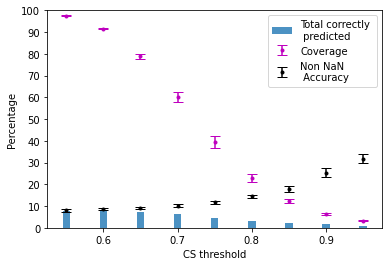

In [31]:
plot_round(coverage_raw,acuracy_raw)

## scatter plot for above graph 

0.55
ave % of non nan predictions
0.9752495492294416
0.076092621547167
acc
------


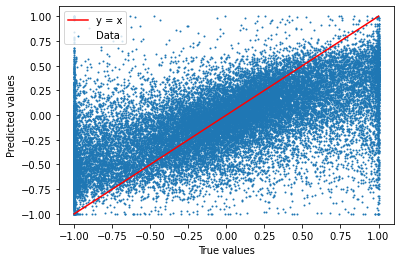

0.20541375718724142
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0.6000000000000001
ave % of non nan predictions
0.9163387889893199
0.08282009724473258
acc
------


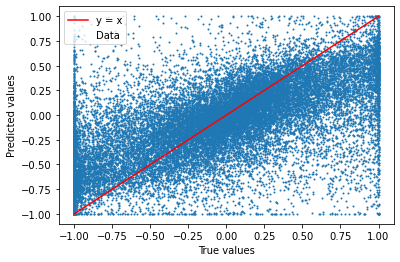

0.20442146851284815
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0.6500000000000001
ave % of non nan predictions
0.7837570911010546
0.09035835779859266
acc
------


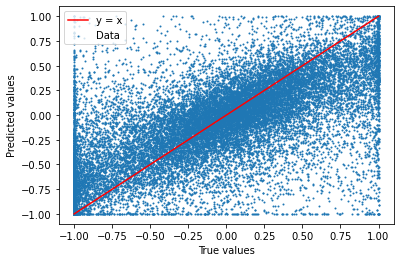

0.19641129547806685
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0.7000000000000002
ave % of non nan predictions
0.5852990918821027
0.10149855181967006
acc
------


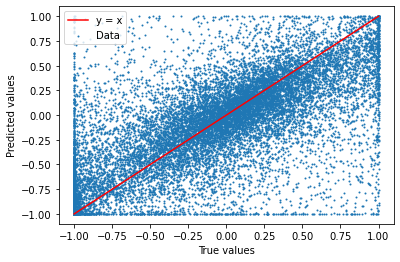

0.18362893923078352
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0.7500000000000002
ave % of non nan predictions
0.3711549303470339
0.11873455264458725
acc
------


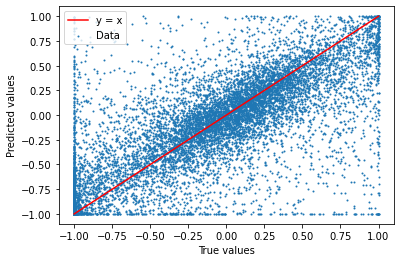

0.16239561010271103
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0.8000000000000003
ave % of non nan predictions
0.21209540545180436
0.14991334488734837
acc
------


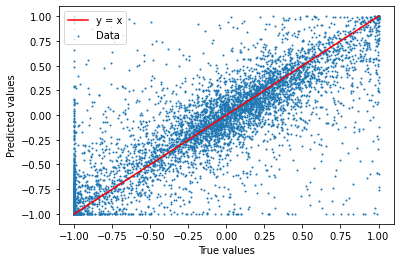

0.11386842573437048
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0.8500000000000003
ave % of non nan predictions
0.11665811956246064
0.19352811812755263
acc
------


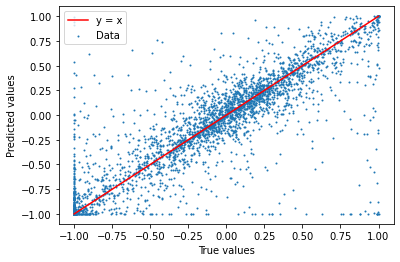

0.09232824628088135
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0.9000000000000004
ave % of non nan predictions
0.062096817024475115
0.24896019013666074
acc
------


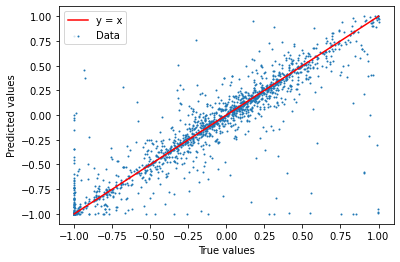

0.056787674813184204
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0.9500000000000004
ave % of non nan predictions
0.03111242065956586
0.30342384887839435
acc
------


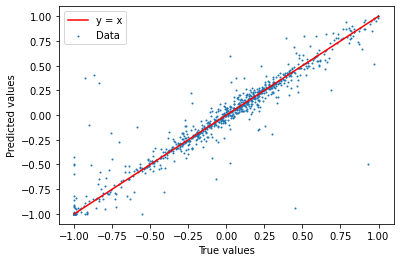

0.0211734029377973
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


In [12]:
RANGE_CS_THRESHOLDS = np.arange(0.55,0.96,0.05)
predicted_valsL = []
true_valsL = []
for threshold in RANGE_CS_THRESHOLDS:
    print(threshold)
    testR = run_model(CS_dataEfcMCF7,CS_errorEfc,test_dataMCF7,StandardErr_rawData ,threshold)
    predicted_vals,true_vals,mean_coverage,acc = find_non_na_err_predicitons(testR)
    predicted_valsL.append(predicted_vals)
    true_valsL.append(true_vals)
    plt.scatter(true_vals,predicted_vals,s = 1,label = 'Data')
    plt.plot([-1,0,1],[-1,0,1],'r', label = 'y = x')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.show()
    print(mean_squared_error(true_vals,predicted_vals))
    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

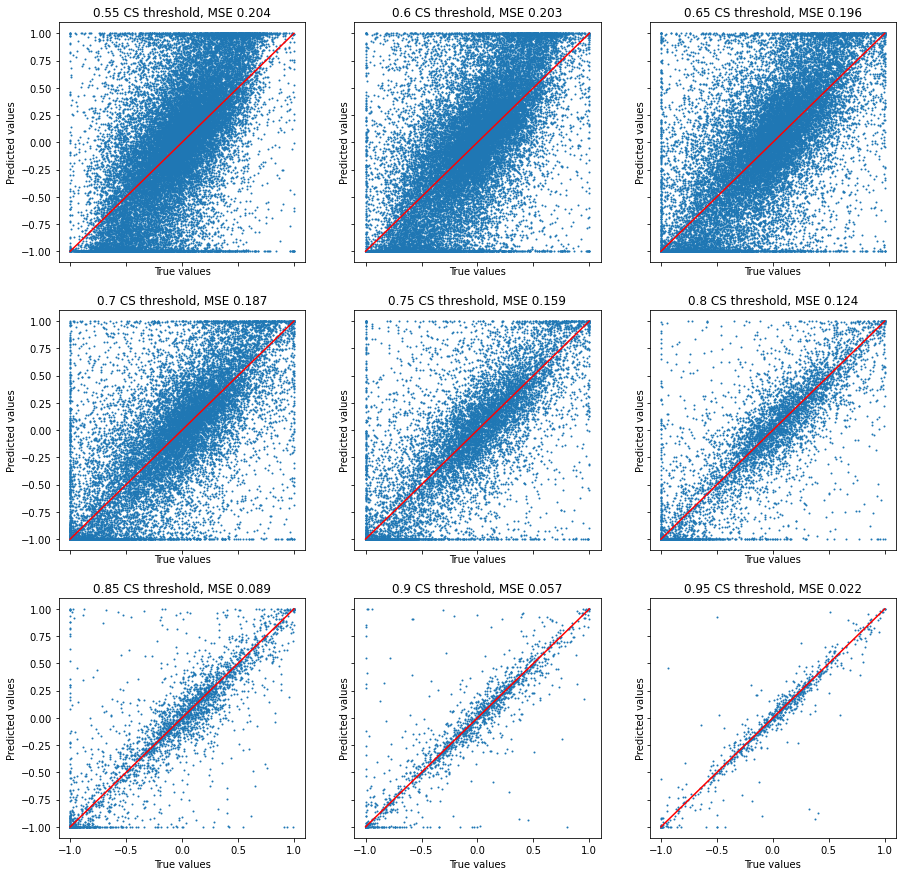

In [13]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True,figsize = (15,15) )
p = 0 
MSEL = np.array([0.20359202640947935,0.20276521596811048,0.19644920634145485,0.18704052728204268,0.15909590697323867,
      0.12442989298147182,0.08880231560511434,0.05700749598377664,0.02225165607036665])
MSEL = np.round(MSEL,3)
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(predicted_valsL[p],true_valsL[p], s = 1)
        ax[i,j].plot([-1,0,1],[-1,0,1],'r', label = 'y = x')
        ax[i,j].set_xlabel('True values')   
        ax[i,j].set_ylabel('Predicted values')
        ax[i,j].set_title(str(np.round(RANGE_CS_THRESHOLDS[p],2) ) + ' CS threshold, ' + 'MSE ' + str(MSEL[p]))
        p = p + 1
plt.show()

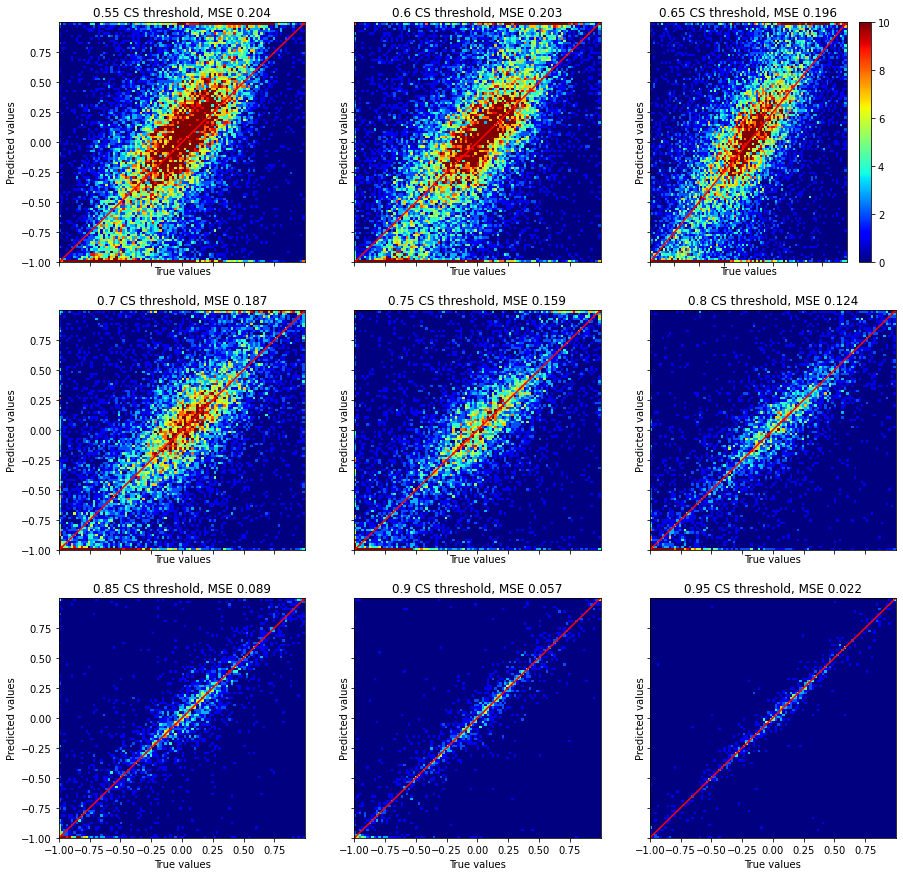

In [97]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True,figsize = (15,15) )
p = 0 
MSEL = np.array([0.20359202640947935,0.20276521596811048,0.19644920634145485,0.18704052728204268,0.15909590697323867,
      0.12442989298147182,0.08880231560511434,0.05700749598377664,0.02225165607036665])
MSEL = np.round(MSEL,3)
for i in range(3):
    for j in range(3):
        pcm = ax[i,j].hist2d(predicted_valsL[p],true_valsL[p],(100,100),cmap=plt.cm.jet,vmin = 0,vmax = 10)
        ax[i,j].plot([-1,0,1],[-1,0,1],'r', label = 'y = x')
        #fig.colorbar(pcm, ax=ax[i,j])
        ax[i,j].set_xlabel('True values')   
        ax[i,j].set_ylabel('Predicted values')
        ax[i,j].set_title(str(np.round(RANGE_CS_THRESHOLDS[p],2) ) + ' CS threshold, ' + 'MSE ' + str(MSEL[p]))
        p = p + 1
fig.colorbar(pcm[3], ax =ax[0,2] )
#plt.colorbar(pcm[3])
plt.show()

In [23]:
np.mean(acuracy_raw,axis = 0)

array([0.65855144, 0.67811406, 0.69441755, 0.71788763, 0.75511756,
       0.79723148, 0.8464378 , 0.89427294, 0.94413058])

In [24]:
np.mean(coverage_raw,axis = 0)

array([0.97630211, 0.91516675, 0.78876618, 0.60291084, 0.39500121,
       0.22695549, 0.12143405, 0.06343863, 0.03208461])

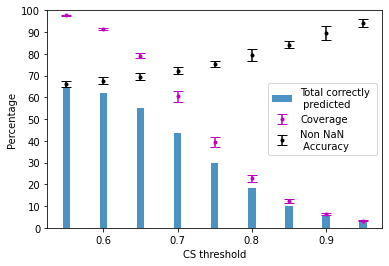

In [85]:
RANGE_CS_THRESHOLDS = np.arange(0.55,0.96,0.05)
plot_round(coverage_raw,acuracy_raw)

## Other cell lines
### HL60

In [10]:
#funs that only need to be run ones for mulitple models with differnt cos_sim 
rang_CS_thresholds = np.arange(0.55,0.96,0.05)
file_pathFC,file_pathErrorCS = 'Other_cellLines/ctamdb_data_fcs_HL60.csv','Other_cellLines/CS_error_Erf_ML60.csv' 
file_path_pval,fp_drop_sites = 'Other_cellLines/ctamdb_data_pvals_HL60.csv','Other_cellLines/ML60_remove_sites'

squashed_dataHL60,CS_errorEfcHL60,StandardErr_rawDataHL60 = pre_process(file_pathFC,file_pathErrorCS,
                                                            file_path_pval,fp_drop_sites)
#coverage_rawHL60,acuracy_rawHL60 = cv(rang_CS_thresholds,squashed_dataHL60,CS_errorEfcHL60)
#plot_round(coverage_rawHL60,acuracy_rawHL60)

should match:
(61, 11143) (61, 11143)


In [46]:
coverage_rawHL60,acuracy_rawHL60 = cv(rang_CS_thresholds,squashed_dataHL60,CS_errorEfcHL60,StandardErr_rawDataHL60)

0
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
168.23662161827087
-----
12
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
172.57120370864868
-----
24
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
169.8552348613739
-----
36
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
174.7623438835144
-----
48
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
171.15497541427612
-----


In [53]:
np.mean(acuracy_rawHL60,axis = 0)

array([0.66945664, 0.68264263, 0.70239184, 0.73176234, 0.76783455,
       0.8098391 , 0.84495271, 0.88215955, 0.93191881])

In [51]:
np.mean(coverage_rawHL60,axis = 0)

array([0.97686063, 0.91684327, 0.79903536, 0.62186649, 0.42517256,
       0.26280892, 0.14715116, 0.07617674, 0.0355094 ])

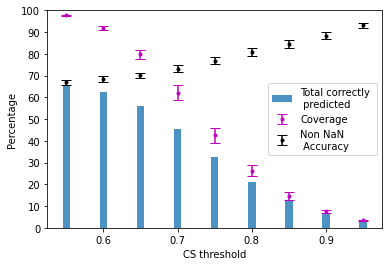

In [55]:
RANGE_CS_THRESHOLDS = rang_CS_thresholds
plot_round(coverage_rawHL60,acuracy_rawHL60)

### NTERA2

In [11]:
rang_CS_thresholds = np.arange(0.55,0.96,0.05)
file_pathFC,file_pathErrorCS = 'Other_cellLines/ctamdb_data_fcs_NTERA2.csv','Other_cellLines/CS_error_Erf_NTERA2.csv' 
file_path_pval,fp_drop_sites = 'Other_cellLines/ctamdb_data_pvals_NTERA2.csv','Other_cellLines/NTERA2_remove_sites'

squashed_dataNTERA2,CS_errorEfcNTERA2,StandardErr_rawDataNTERA2 = pre_process(file_pathFC,file_pathErrorCS,
                                                            file_path_pval,fp_drop_sites)

should match:
(61, 11445) (61, 11445)


In [57]:
coverage_rawNTERA2,acuracy_rawNTERA2 = cv(rang_CS_thresholds,squashed_dataNTERA2,
                                          CS_errorEfcNTERA2,StandardErr_rawDataNTERA2)


0
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
182.57141399383545
-----
12
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
180.52504324913025
-----
24
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
182.84647226333618
-----
36
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
182.19450998306274
-----
48
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
177.890789270401
-----


In [61]:
np.mean(acuracy_rawNTERA2,axis = 0)

array([0.68799674, 0.70185124, 0.72539697, 0.75308061, 0.79075668,
       0.82837757, 0.86486705, 0.90835449, 0.94462987])

In [62]:
np.mean(coverage_rawNTERA2,axis = 0)

array([0.97171129, 0.90840648, 0.77844224, 0.58974321, 0.3874358 ,
       0.22123882, 0.11914284, 0.06344653, 0.03246252])

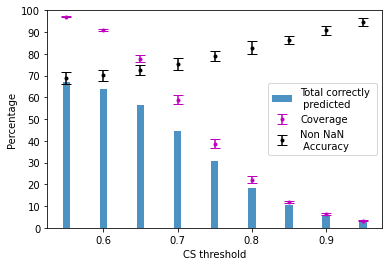

In [60]:
RANGE_CS_THRESHOLDS = rang_CS_thresholds
plot_round(coverage_rawNTERA2,acuracy_rawNTERA2)

In [31]:
def Overlap_test(data,cosSimX,CS_data,SE_rawData): #test the model useing the tranning data or testing data
    #tests the model       
    data_copy = data.copy(deep=True)
    err_data_subset = SE_rawData.iloc[train_indx]
    #find the sites that will become unseen
    rand = np.random.rand(len(data),len(data.T))
    nan_col_list = []
    true_vals = []
    # work out a way to do this in one go, if runnning time too long. (should't take too long only 61 loop)
    for i,r in zip(range(0,len(data)),rand): 
        nan_cols = data.columns[(r>0.8)]
        true_vals.append(data.iloc[i][nan_cols])
        data_copy.iloc[i][nan_cols] = np.nan #sets these sites to NaN/unseen
        nan_col_list.append(nan_cols)
        
    #loops over the columbs for each treatment, and the index of the treatment in the test dataset 
    y_test = [] #final predcited values
    true_nonNan = []
    true_nonNanErr = []
    for treatment_ind,cols in enumerate(nan_col_list):
        row_PV = []
        Ttrue_nonNan = []
        Ttrue_nonNanErr = []
        for site in cols: #loops over the sites that need predicting
            try:
                sim_sites = cosSimX.loc[site].dropna().index #this is where the 'model/traning data is used'
                #CS_sim_site = CS_data.loc[site][sim_sites].values #finds the CS of above sites for wighted mean
            except KeyError:
                predictedVal = np.nan 
                sim_sites = []
            #should be able to take this next line out? 
            if len(sim_sites) == 0: #if there is no simliar sites than we can't predict a value, so keep it as nan
                predictedVal = np.nan 
            else: #else use the values from the test dataset and the simliar sites to predict a value
                #uses the mean weighted by the cos sim of the sites
                sim_sites_overlap = []
                for s in sim_sites:
                    try:
                        data_copy.iloc[treatment_ind][s]
                        sim_sites_overlap.append(s)
                    except KeyError:
                        pass     
                predictedVal = np.mean(data_copy.iloc[treatment_ind][sim_sites_overlap].dropna())
                """
                if meanT == False:
                    SimSvals = data_copy.iloc[treatment_ind][sim_sites]
                    if len(SimSvals.dropna()) > 0:
                        predictedVal1 = np.mean(SimSvals)
                        mask = np.isnan(SimSvals) == False 
                        CS_sim_site = CS_sim_site[mask]
                        predictedVal = np.average(SimSvals.dropna(),weights=CS_sim_site)
                """
                if np.isnan(predictedVal) == True:
                    pass
                else:
                    nonNan_t = data[site][treatment_ind]
                    #nonNan_t_err = err_data_subset[site][treatment_ind]
                    Ttrue_nonNan.append(nonNan_t)
                    #Ttrue_nonNanErr.append(nonNan_t_err)
            row_PV.append(predictedVal)
        y_test.append(row_PV)
        true_nonNan.append(Ttrue_nonNan)
        #true_nonNanErr.append(Ttrue_nonNanErr)

    return y_test,true_nonNan,['empty']

def run_modelOverlap(CS_data_train,err_df,test_data,SE_rawData,threshold):
    cosSimX = Find_sim_sitesQ(CS_data_train,err_df,threshold)
    y_test,true_nonNan,true_nonNanErr = Overlap_test(test_data,cosSimX,CS_data_train,SE_rawData)
    testR = [y_test,true_nonNan,true_nonNanErr]
    return testR

In [101]:
CS_dataEfcMCF7

pst,AAAS(S495),AAGAB(S310),AAGAB(S311),AAK1(S14),AAK1(S21),AAK1(S637),AAK1(S678),AAK1(T389),AAK1(T606),AAK1(T653),...,ZYX(S267),ZYX(S281),ZYX(S308),ZYX(S344),ZYX(T270),ZYX(T274),ZZEF1(S1464),ZZEF1(S1518),ZZZ3(S113),ZZZ3(S82)
pst,,,,,,,,,,,,,,,,,,,,,
AAAS(S495),0.000000,-0.072518,-0.168659,0.184628,0.154390,0.284739,-0.360718,0.208989,-0.200314,0.153965,...,0.178829,-0.099170,0.168166,0.407629,0.197907,-0.001944,-0.009110,0.074034,-0.026691,-0.121801
AAGAB(S310),-0.072518,0.000000,0.814875,0.077203,0.219456,0.063377,0.150161,-0.238933,-0.000160,-0.065483,...,0.113603,-0.169262,-0.313942,-0.063908,-0.132016,0.265012,0.144376,0.084747,0.024454,0.189872
AAGAB(S311),-0.168659,0.814875,0.000000,0.140552,0.236784,0.055406,0.254230,-0.420578,0.236047,0.068561,...,0.127144,-0.156468,-0.258946,-0.093099,-0.342239,0.165804,0.105957,0.228299,-0.205474,0.084911
AAK1(S14),0.184628,0.077203,0.140552,0.000000,0.567227,-0.011053,0.091837,0.509945,-0.063162,-0.009310,...,0.001862,0.124185,0.143722,0.488655,0.132228,0.248623,-0.173268,-0.007694,0.032841,0.214056
AAK1(S21),0.154390,0.219456,0.236784,0.567227,0.000000,-0.065524,-0.021570,0.094608,-0.022517,-0.046395,...,0.197962,0.434039,-0.025135,0.228561,0.027204,0.430518,-0.004085,-0.022692,0.117200,0.450642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX(T274),-0.001944,0.265012,0.165804,0.248623,0.430518,0.024174,0.156800,0.021741,-0.102543,-0.166750,...,0.257287,0.373384,0.156695,0.189160,0.503707,0.000000,-0.224195,-0.069431,0.279437,0.372610
ZZEF1(S1464),-0.009110,0.144376,0.105957,-0.173268,-0.004085,-0.016643,-0.188544,-0.206601,0.069478,0.053726,...,-0.046137,-0.155915,-0.315318,-0.363821,-0.404171,-0.224195,0.000000,0.118333,0.165888,0.035170
ZZEF1(S1518),0.074034,0.084747,0.228299,-0.007694,-0.022692,0.043889,-0.055125,-0.191761,0.013127,0.383910,...,-0.177069,-0.006764,0.161505,0.050650,-0.172698,-0.069431,0.118333,0.000000,-0.032489,-0.079522


In [95]:
test_data

pst,AAAS(S495),AAK1(S14),AAK1(S21),AAK1(S637),AAK1(S678),AAK1(T389),AAK1(T606),AAK1(T653),AATF(S203),AATF(S316),...,ZYX(S267),ZYX(S281),ZYX(S308),ZYX(S344),ZYX(T270),ZYX(T274),ZZEF1(S1464),ZZEF1(S1518),ZZZ3(S113),ZZZ3(S82)
AC220,-0.037450,0.604265,-0.725402,0.919113,0.565959,-0.862914,0.477882,0.391506,0.628922,-0.981187,...,-0.059670,-0.139964,-0.113007,-0.176470,-1.000000,-0.783349,0.999155,0.049855,0.169952,0.106728
AT13148,-0.082947,-0.520281,0.342320,-1.000000,0.799999,0.002781,-0.068503,0.216143,-0.113082,0.538565,...,0.274854,0.010003,0.028991,-0.138003,-1.000000,-0.957584,-1.000000,-0.731676,-0.261441,-0.170967
AZ20,-0.024302,-0.989948,-0.455019,0.422970,0.669293,-0.324870,-0.312754,-0.016975,-0.112027,-0.899537,...,0.478366,0.511648,0.607219,0.526856,0.991630,0.808804,0.361764,-0.230096,-0.321868,-0.223698
AZD1480,0.223341,-0.388944,0.315923,0.946651,0.942067,0.445636,-0.282023,0.703802,0.520294,-1.000000,...,-0.213077,-0.215778,-0.298451,0.829331,-1.000000,0.902029,-0.536299,-0.005068,0.358728,-0.090673
AZD3759,0.127167,-0.948558,0.592264,0.828066,-1.000000,0.402430,0.274770,0.868676,0.637739,-1.000000,...,-0.022209,0.262755,-0.175135,0.278929,-0.999610,0.952149,-1.000000,-0.016969,0.279199,0.853976
AZD5363,-0.027030,-0.093903,0.512837,0.945888,-1.000000,0.356914,-0.187152,0.655401,0.555801,-0.999451,...,-0.001046,-0.150150,0.109386,0.820462,0.999968,0.414343,-0.341829,0.333787,0.076838,0.121849
AZD5438,-0.098365,-0.322080,-0.498983,-0.332673,0.843668,-0.325151,0.156147,-0.019756,0.559356,-0.117240,...,-0.771690,-0.778780,-0.010724,-0.477346,-1.000000,-0.547284,-0.264212,0.704043,-0.397026,-0.986157
AZD6482,0.317823,-0.452736,0.277701,-0.106293,0.650411,-0.010537,-0.205693,-0.033262,-0.181076,-0.999975,...,-0.027794,-0.031126,0.170903,0.154701,-1.000000,-0.140623,-0.039387,0.282974,0.367457,0.054528
AZD6738,-0.048803,-0.999998,0.087911,0.228904,0.723893,-0.332274,-0.272431,0.138403,-0.377363,0.264186,...,0.556380,0.616195,0.684748,0.561739,0.989550,-0.041090,-0.484781,-0.196390,-0.555393,-0.173393
AZD8055,-0.127175,0.362451,-0.499729,0.921238,-1.000000,-0.576084,0.207531,0.122838,0.294001,0.369487,...,0.090613,0.427316,0.309032,0.080230,-1.000000,0.990339,-0.056076,-0.322935,-0.573980,-0.174605


In [34]:
testROverlap = run_modelOverlap(CS_MCF7,StandardErr_rawData,test_HL60,StandardErr_rawData,0.8)

ABCF1(S109)
['ABCF1(T108)', 'ZNF462(S350)']
-0.335402083370489
0.08353470319128714
----------
ABCF1(S228)
['DDX54(S782)', 'HNRNPC(S299)', 'HNRNPUL2(S161)', 'HSP90AA1(S263)', 'HSP90AB1(S255)', 'MARCKS(T150)', 'MYH9(S1943)', 'NUCKS1(S61)', 'SRRM1(S465)', 'ZC3H18(S67)']
-0.43794835428629525
-0.5528392589159712
----------
ABCF1(T108)
['ABCF1(S109)', 'GATAD2A(S100)', 'GATAD2A(S107)']
-0.4793364440216014
-0.37521170463874265
----------
ACKR3(S350)
['AATF(S203)']
0.6289219015461373
-0.8115691709999145
----------
ADAM10(T719)
['ALYREF(S8)', 'ARFGAP3(S150)', 'ARHGEF18(S1160)', 'ATP2B4(S13)', 'CCDC88B(S1408)', 'DBNL(S232)', 'EML3(S177)', 'FAM126A(S433)', 'FAM126A(S453)', 'FNBP1L(S488)', 'GIGYF2(T382)', 'GPR183(S343)', 'GPRASP2(T230)', 'HCLS1(T308)', 'HMGCR(S508)', 'KATNA1(S109)', 'KCNAB2(S112)', 'KNOP1(T308)', 'MAPRE1(S165)', 'MARK4(T214)', 'MIS18BP1(S690)', 'MSN(S576)', 'NF1(S2515)', 'NHSL2(T320)', 'PAK1(S115)', 'PDE3A(S312)', 'PELP1(S485)', 'PLEKHA5(S526)', 'POLR3D(S42)', 'PPIP5K2(S38)', 'PRR1

EPS15L1(S108)
['DAP(S51)', 'FTH1(S183)', 'NUP160(S1157)', 'PGM1(S117)', 'USP7(S963)']
-0.12226148909348503
0.9277852761594728
----------
ERBIN(S1168)
['MEPCE(S152)', 'MYBBP1A(S1186)', 'RBM14(S618)']
-0.28184877912870615
0.3149012803214611
----------
ERC1(S191)
['MTBP(S639)']
-0.2548057532941718
-0.10151960622356175
----------
ERCC5(S341)
['BASP1(S164)']
0.3889866253468678
0.37886651093731283
----------
ERCC5(S526)
['EIF4G3(S230)', 'KANSL1(S249)', 'ZBTB40(S190)']
-0.3486255552553823
0.3139145249335241
----------
EXOC1(S472)
['EXOC1(S473)']
0.028074315489997524
-0.2595681794234612
----------
FAM126A(S433)
['ADAM10(T719)', 'EML3(S177)', 'GPR183(S343)', 'GPRASP2(T230)', 'KNOP1(T308)', 'MIS18BP1(S690)', 'MSN(S576)', 'PAK1(S115)', 'PDE3A(S312)', 'SPN(S291)', 'TBC1D4(S591)', 'TOE1(S5)', 'YBX3(S324)']
-0.6776151646625482
-0.13805250963017257
----------
FAM169A(S635)
['FAM169A(S636)']
0.2084212656666764
-0.11537958920738602
----------
FAM177A1(S70)
['FAM177A1(T71)', 'GORASP2(S451)', 'LARP1(S627

NAA30(S199)
['ARGLU1(S77)', 'CTNND1(S252)', 'KNOP1(S132)', 'MISP3(S91)', 'PPP1R12A(S422)', 'SRRM2(T1856)', 'TNS3(S874)']
0.3860787078524643
-0.15249562550220908
----------
NCOR1(S1111)
['CDC25A(S18)']
-0.039225595698839114
-0.3430779612053786
----------
NCOR1(S158)
['NCOR1(S172)']
-1.0
-0.9342180026692771
----------
NCOR2(S1018)
['RSF1(S622)']
0.21330704693337585
0.6300971596413327
----------
NCOR2(S2065)
['NCOR2(S2057)']
-0.37668683427063465
-0.14322683330466543
----------
NDRG2(T334)
['NDRG2(S332)']
-0.9877666291331291
0.8605120121937848
----------
NEDD1(S468)
['PRPSAP1(S215)']
0.9646880972008822
0.9999993577995921
----------
NEK1(S664)
['DBNL(S232)', 'DDX24(S82)', 'DDX39B(S38)', 'EEF2(S595)', 'FAM126A(S453)', 'GIGYF2(T382)', 'MAPRE1(S165)', 'MARK3(T491)', 'MIS18BP1(S690)', 'NUCKS1(S54)', 'PAK1(S115)', 'PELP1(S485)', 'SRSF2(S101)', 'TRPS1(S805)', 'YBX3(S324)', 'ZNF652(S204)']
0.044826730858119786
0.317747149384554
----------
NFIB(S328)
['NFIB(S332)']
-0.9960720420041778
-0.9969526313

0.5503287301226056
0.5659608157045681
----------
SIRT6(T337)
['SIRT6(S338)', 'SRRM1(S450)']
0.7110118487467136
0.9999999999999997
----------
SLAIN2(S413)
['YV023_HUMAN(S109)']
nan
SLC38A2(Y41)
['AXIN1(S77)']
-0.42235040462036005
-1.0
----------
SLC43A1(S267)
['ARFGAP3(S150)', 'ATP2B4(S13)', 'BSN(S1362)', 'DDX21(S168)', 'DOCK11(S1237)', 'DPF2(S244)', 'GPR183(S343)', 'PAK1(S115)', 'PDE3A(S312)', 'PRAG1(S907)', 'UVRAG(S689)']
-0.623760370357565
0.2341278516542241
----------
SMARCA2(S1377)
[]
nan
SMARCC1(S330)
['RBM15(S670)', 'SMARCC1(S328)']
0.04368661408494838
0.057636237663776305
----------
SMARCC1(T398)
[]
nan
SMARCC2(S347)
['C1orf174(S189)']
-1.0
0.17689128365576354
----------
SMG1(T3573)
['SMG1(S3570)', 'TJP1(S131)']
0.3604387243980046
-0.09549759502390467
----------
SMTN(S729)
['ADNP(S709)', 'DYNC1LI1(S421)', 'GTSE1(S536)', 'PDLIM5(S111)', 'SEPTIN9(T49)']
-0.20168057617936125
0.015113177187029802
----------
SNRNP200(S225)
['GPN1(S338)', 'HSP90AA1(S263)', 'PDCD5(S119)', 'ZRANB2(S153)

ANLN(S295)
['ALYREF(S8)', 'ARHGEF40(T1074)', 'CCDC88B(S1408)', 'DBNL(S232)', 'FNBP1L(S488)', 'GIGYF2(T382)', 'GPRASP2(T230)', 'KNOP1(T308)', 'MAP1B(S1208)', 'NF1(S2515)', 'SRSF2(S101)', 'TOR4A(S63)', 'TTYH2(S444)', 'ZNF652(S204)']
-0.14007871356828774
-1.0
----------
APRT(S30)
['GAPDH(S210)']
0.013001513763136626
-0.04932241207638956
----------
ARFGAP2(S432)
['DBNL(T291)', 'R3HDM2(S349)', 'TBC1D10C(T439)']
0.525809300759879
0.5333066083603476
----------
ARFGAP3(S150)
['ADAM10(T719)', 'ATP2B4(S13)', 'BSN(S1362)', 'DDX21(S168)', 'DPF2(S244)', 'EML3(S177)', 'GIGYF2(T382)', 'GPR183(S343)', 'GPRASP2(T230)', 'HCN4(S57)', 'KCNAB2(S112)', 'MIS18BP1(S690)', 'NDRG1(T375)', 'NF1(S2515)', 'NUP205(S1153)', 'PAK1(S115)', 'PDE3A(S312)', 'POLR3D(S42)', 'PPIP5K2(S38)', 'PRAG1(S907)', 'RAMAC(S86)', 'SLC43A1(S267)', 'TBC1D4(S591)', 'TOE1(S5)', 'TOR4A(S63)', 'TRIM24(S744)', 'TRPS1(S805)', 'UVRAG(S689)', 'YBX3(S324)', 'ZBTB33(S237)', 'ZNF652(S204)']
-0.23698158824501234
-1.0
----------
ARHGAP10(S591)
['RBM

['ACTBL2(Y295)', 'ADAM10(T719)', 'ALYREF(S8)', 'ANLN(S295)', 'ARFGAP3(S150)', 'ARHGEF18(S1160)', 'ATP2B4(S13)', 'CCDC88B(S1408)', 'CLDN6(Y200)', 'DBNL(S232)', 'DPF2(S244)', 'EEF2(S595)', 'EML3(S177)', 'ERCC5(S1069)', 'FAM126A(S433)', 'FAM126A(S453)', 'FLNC(S2624)', 'FNBP1L(S488)', 'GIGYF2(T382)', 'GPR183(S343)', 'HCLS1(T308)', 'HMGCR(S508)', 'KATNA1(S109)', 'KCNAB2(S112)', 'KNOP1(T308)', 'LCP1(S257)', 'LUZP1(S878)', 'MAP4K4(S868)', 'MAPRE1(S165)', 'MARK3(T491)', 'MARK4(T214)', 'MDC1(S995)', 'MIS18BP1(S690)', 'MSN(S576)', 'NEFM(S736)', 'NF1(S2515)', 'NHSL2(T320)', 'NSRP1(T275)', 'NUCKS1(S54)', 'PAK1(S115)', 'PDE3A(S312)', 'PELP1(S485)', 'PLEKHA5(S526)', 'POLR3D(S42)', 'PPIP5K2(S38)', 'PRR14L(S582)', 'PSMG1(T18)', 'RAP1GAP2(S45)', 'RBBP6(S1221)', 'RPLP2(S16)', 'RRP12(S4)', 'SLBP(T123)', 'SLC4A7(S55)', 'SRSF2(S101)', 'TBC1D4(S591)', 'TCF12(S67)', 'TOE1(S5)', 'TOR4A(S63)', 'TRPS1(S805)', 'UVRAG(S689)', 'YBX3(S324)', 'ZBTB33(S237)', 'ZC3HAV1(S494)', 'ZNF407(S994)', 'ZNF462(S295)', 'ZNF516(S

NUCKS1(S61)
['ABCF1(S228)', 'DDX54(S782)', 'HNRNPUL2(S161)', 'HSP90AB1(S255)', 'MYH9(S1943)', 'NUCKS1(S58)', 'SRRM1(S465)', 'ZC3H18(S67)', 'ZC3H18(S74)']
0.5366799309593877
0.75969654532767
----------
NUFIP2(S652)
['CAAP1(S312)']
0.01593130025818163
0.19116305261188707
----------
NUP160(S1157)
['CDK1(T161)', 'CDK2(T160)', 'EPS15L1(S108)', 'SIN3A(S277)', 'USP7(S963)']
-0.20189364734067353
-1.0
----------
NUP205(S1153)
['ARFGAP3(S150)']
nan
NUP35(S66)
['CDK5RAP2(S1238)', 'ELAVL1(S202)', 'PDCD6IP(S730)', 'STRN(S376)']
-0.19117804067357144
-0.24603889550700878
----------
NUP35(S73)
['FNBP4(S18)', 'IRF2BP2(S406)', 'SPICE1(T235)']
-0.038418813113723964
0.013152357832410786
----------
OTUD5(S508)
['ZCCHC8(T479)']
0.06582766513085614
-0.2104692906963758
----------
PABIR1(S143)
['PABIR1(S147)']
nan
PABIR1(S147)
['FIP1L1(S259)', 'PABIR1(S143)', 'ZNF574(S164)']
0.06853444710875845
0.24016046159542906
----------
PABIR2(S115)
['PABIR2(S119)']
-0.03343774973991582
-0.06590840246818823
----------
PAC

SLX4(S584)
['TJP2(S979)', 'VCPIP1(S768)']
-0.1312010701532559
-0.4317635048304138
----------
SMAP2(S219)
['ASF1B(T179)']
-0.22153860197398106
-0.040315091155471945
----------
SMARCC2(S302)
['SMARCC2(S304)', 'SPTBN1(S2102)']
0.46665149994971766
0.7215265895346208
----------
SNTG2(T75)
['SIX3(S219)']
0.9817999089730896
0.988318881444563
----------
SNX17(S437)
['SNX17(S440)']
nan
SNX17(S440)
['SNX17(S437)']
nan
SON(S94)
['ABLIM1(S655)', 'ARHGEF5(S606)', 'DDX17(S571)', 'GSK3A(S21)', 'LARP1(S1056)', 'PDAP1(S176)', 'PI4K2A(S462)', 'RPS6KB1(S427)', 'SART1(S448)', 'SERBP1(S203)', 'SH3PXD2B(S291)', 'YBX1(S209)']
-0.6741885919054261
0.06510783947968685
----------
SORBS1(S475)
['EIF4G3(S232)']
0.06794973580594796
0.08794894200097697
----------
SQSTM1(S284)
['CDK11A(S740)', 'CDK11A(T739)', 'GATAD2A(S107)']
-0.1844410036637516
-0.07246048724019628
----------
SQSTM1(S365)
['CD2AP(S189)', 'DOCK11(S1237)']
-0.46531259063961294
0.9885487609945433
----------
SRRM1(S393)
['PCYT1A(S331)', 'SRRM1(S389)']
0

-0.17039460756508065
-0.22556204124373155
----------
ATF1(S198)
['MAVS(S258)', 'TNKS1BP1(S1715)']
0.08657501061416065
0.7359375102693352
----------
ATF7IP(S477)
['ATRX(S34)', 'PSMD1(S304)', 'PSMD1(S315)', 'PTPN12(S673)', 'PXN(S303)', 'SSB(S94)', 'SUDS3(S234)', 'SUDS3(S237)', 'YY1(S187)']
-0.16131282853708745
-0.5164894926124255
----------
ATP13A1(S899)
['EIF2AK3(S715)', 'ZFHX3(S1590)']
-0.15365993419777374
-0.03934161754789024
----------
ATP2B4(S13)
['ADAM10(T719)', 'ANKRD63(S193)', 'ARFGAP3(S150)', 'BSN(S1362)', 'DPF2(S244)', 'EML3(S177)', 'GIGYF2(T382)', 'GPRASP2(T230)', 'HCLS1(T308)', 'HCN4(S57)', 'IRS1(T311)', 'KCNAB2(S112)', 'MIS18BP1(S690)', 'MSN(S576)', 'NEFM(S736)', 'NF1(S2515)', 'PAK1(S115)', 'PDE3A(S312)', 'POLR3D(S42)', 'PPIP5K2(S38)', 'PRAG1(S907)', 'SLC43A1(S267)', 'TBC1D4(S591)', 'TOE1(S5)', 'TOR4A(S63)', 'TRIM24(S744)', 'TRPS1(S805)', 'UVRAG(S689)', 'YBX3(S324)', 'ZBTB33(S237)', 'ZNF652(S204)']
-0.28836398033831084
-0.45998417144817905
----------
ATP5F1C(S146)
['MEF2D(S1

JPT1(T54)
['PAICS(S27)', 'TK1(S231)']
0.5718358109250873
0.6359849465461234
----------
JPT2(S30)
['ADNP(S709)', 'ATXN2L(S424)', 'DYNC1LI1(S421)', 'HMGA1(S36)', 'HNRNPA1(S338)', 'LMNB1(S23)', 'NOLC1(T607)', 'NOLC1(T610)', 'PSMA5(S16)', 'RSL1D1(T465)', 'SURF6(T229)']
0.43818749130276763
0.5933568889009783
----------
JPT2(T76)
['SMTN(S341)']
-1.0
-0.7637622499496681
----------
KANK2(S375)
['ATXN1(S88)', 'DSG2(T922)', 'GAPDH(S210)', 'GLCCI1(T81)', 'IRF2BP2(S406)', 'KIF1C(S915)', 'MICALL1(S471)', 'PHF12(T671)']
-0.35230510355373434
-0.09018420347918009
----------
KANSL1(S249)
['ERCC5(S526)', 'WDCP(S690)']
-0.2422676655033651
-0.37558289588806915
----------
KAT6B(S1581)
['ZNF281(S651)']
-0.15379002906576197
-0.5284935625132717
----------
KCNT1(S93)
['PREPL(T440)']
-0.910857332788912
-0.9108573327889173
----------
KIAA0753(S301)
['KRT8(S330)']
nan
KLF3(S92)
['KLF3(S101)']
0.4206726365818819
0.16898782690588893
----------
KMT2D(S654)
['IQGAP1(S330)', 'KANSL1(S991)', 'ZNF579(S483)']
-0.35691724

PROSER2(T45)
['ACLY(S455)', 'ARHGEF12(S1288)', 'DBNL(S232)', 'DDX17(S571)', 'DOCK4(S1808)', 'EHMT2(S232)', 'GIGYF2(T382)', 'GSK3A(S21)', 'LUZP1(S878)', 'PATL1(S184)', 'RPLP2(S16)', 'RPS6KB1(S427)', 'YBX1(S209)', 'ZNF185(S64)']
-0.11210745752659293
0.017397915336464315
----------
PRPF3(S619)
['RBM39(S136)', 'RSF1(S622)', 'SON(S1556)', 'WDHD1(S868)']
-0.05906932339848102
0.34294028826977496
----------
PRPF4B(S427)
['FIP1L1(S492)', 'PRCC(S157)', 'PRCC(S159)']
-0.11047996799097633
-0.26853847793534014
----------
PRPF4B(S852)
['TBX2(S657)']
0.5702113124499771
0.42302761577922526
----------
PRPF4B(S93)
['PRPF4B(S87)']
0.003399140527528937
0.004999550453123198
----------
PRR36(T69)
['ATRX(S34)', 'CSTF3(S691)', 'IRF2BP2(S175)', 'PARN(S619)', 'SRRM1(T220)']
-0.22993802256779539
-0.2878754466564788
----------
PRRT3(S900)
['PRRT3(S903)']
nan
PRRT3(S903)
['PRRT3(S900)']
nan
PSMD1(S315)
['ATF7IP(S477)', 'ATRX(S34)', 'BAG3(T406)', 'BOLA1(S123)', 'CCNL1(S352)', 'CSTF3(S691)', 'GPHN(T198)', 'IRF2BP2(S

TP53BP1(S1094)
['TP53BP1(S1101)']
-0.18422690401945657
-0.2057061114625695
----------
TP53BP1(S1678)
['CIZ1(S838)']
-0.14753798427909198
-0.20089666358633052
----------
TP53BP1(S222)
[]
nan
TPR(T641)
['FGFR1(T454)', 'GIGYF1(S370)', 'MAP4K4(S868)', 'PANK4(T406)', 'POLR1F(S60)', 'PRR14L(S582)', 'YWHAQ(S232)']
-0.7023872850797978
-1.0
----------
TPX2(S486)
['GTSE1(S536)', 'MKI67(S2299)', 'PDLIM5(S111)', 'RSL1D1(T465)']
0.6749499448250145
0.1582853019010324
----------
TRA2A(S262)
['TRA2A(S260)', 'TRA2A(Y264)']
0.03613143485531141
0.025252943171230575
----------
TRA2A(S86)
['TRA2A(T88)']
nan
TRA2A(T88)
['HDGF(S132)', 'HDGF(S133)', 'SRRM2(S2692)', 'TRA2A(S86)']
0.14740294521014985
-0.48082188714666707
----------
TRA2B(S264)
['TRA2B(S266)']
nan
TRA2B(S266)
['TRA2B(S264)']
nan
TRA2B(S99)
['TRA2B(S95)']
-0.992283166662246
-0.6733324682153514
----------
TRIP11(S1891)
['GRAMD1A(S560)']
0.6647917066754302
0.5221631422679194
----------
TRMT2A(S602)
['ANK2(T3797)']
-0.5940985513949889
-0.57293159839

CHD1(S1677)
['SRRM2(T1208)']
0.017571315117500232
0.16177545153514666
----------
CHD3(S1605)
['CHD3(S1601)']
-0.7616936962410128
-0.7303985813530633
----------
CHMP7(S417)
['MKI67(S1376)']
nan
CIC(S496)
['NCOR2(S2269)', 'PGR(S162)']
0.48251890059506625
0.45719760870286563
----------
CIZ1(S838)
['PJA2(S309)', 'TP53BP1(S1678)', 'ZC3H13(S77)']
-0.03039436662459088
0.359266952446227
----------
CTDP1(S456)
['CD2AP(S189)', 'ITPKB(S176)', 'MCM6(S689)', 'OTUD5(S165)', 'TMEM132B(S793)']
-0.6134823925362627
-0.7564250148570373
----------
CTDSPL2(S28)
['ARHGEF5(S606)', 'DDX17(S571)', 'DOCK4(S1808)', 'LARP1(S1056)', 'PDAP1(S176)', 'SERBP1(S203)', 'SH3PXD2B(S291)', 'YBX1(S209)']
0.24680379495714874
-0.19476824132744966
----------
CTNND1(S349)
['CTNND1(S352)']
0.7674098495261131
0.6745549316690742
----------
CTNND1(Y865)
['NOB1(S201)']
-0.3363712040949057
-0.281970064883231
----------
CTPS1(S575)
[]
nan
CTTNBP2NL(S488)
['GAPDH(S210)', 'HSPD1(S70)']
-0.011053599594275848
-0.0015374676796064968
------

0.978836966428704
0.997952619938262
----------
MAP1B(S1438)
['MAP1B(S1443)']
-0.21781751353410592
0.14939439527221127
----------
MAP1S(S472)
['LARP1(S143)', 'RAI1(S1110)']
-0.9255085290547539
-0.2736842059260582
----------
MAP4(S624)
['AKAP13(S1602)']
-1.0
0.6676123128655072
----------
MAP4K4(S868)
['GPRASP2(T230)', 'HCLS1(T308)', 'ITPKB(S49)', 'KNOP1(T308)', 'MIS18BP1(S690)', 'MSN(S576)', 'NF1(S2515)', 'PAK1(S115)', 'PELP1(S485)', 'PRR14L(S582)', 'SLBP(T123)', 'SREBF2(S1098)', 'TOE1(S5)', 'TPR(T641)', 'TRPS1(S805)', 'YBX3(S324)', 'ZNF462(S295)', 'ZNF652(S204)']
0.11239819336262989
-0.37700475324321675
----------
MAP7(S209)
['PATL1(S184)', 'PATL1(T194)']
0.17821680214252997
0.1284419267619954
----------
MAPK1(Y187)
['MAPK1(T185)']
0.014369212607428952
0.08639516051543665
----------
MAPK3(T202)
['MAPK3(Y204)']
-0.3419825823831653
-0.3602090946493723
----------
MAPRE1(S165)
['ADAM10(T719)', 'DBNL(S232)', 'EEF2(S595)', 'EML3(S177)', 'FAM126A(S453)', 'FNBP1L(S488)', 'GIGYF2(T382)', 'GPRASP

RFC1(S71)
['RFC1(S69)', 'RFC1(Y67)']
-0.7503759199310925
-0.5892637893385314
----------
RFC1(Y67)
['RFC1(S69)', 'RFC1(S71)']
-0.7503759199310925
-0.6842471165468894
----------
RGPD4(S1305)
['IRS1(S531)']
0.9999989234155372
-0.9441653973029306
----------
RIC1(T992)
[]
nan
RIC8A(Y435)
['RIC8A(T441)']
-0.9963943437931732
-0.9588691640923701
----------
RIF1(S2161)
['ZNF638(S1401)']
-0.028519167547993045
-0.0395684412643284
----------
RIOK1(S22)
['FIP1L1(S492)', 'KIAA1143(S50)', 'MCM7(S139)']
0.2360763851686761
-0.3774294852822326
----------
RPAP3(S119)
['RPAP3(S116)']
-0.986302178489956
-0.8356996947958406
----------
RPRD2(T723)
['SLC4A7(S233)', 'SON(S1556)']
-0.3393563893172725
-0.09686153449303397
----------
RPRD2(T732)
['DDX42(S185)', 'NCBP3(S25)', 'POLR1G(S490)', 'TP53BP1(S831)', 'WNK1(S2011)']
-0.6152947409053315
-0.5206026976754135
----------
RPS6KB1(S441)
['CCDC81(S648)', 'DDX17(S571)', 'EHMT2(S232)', 'GSK3B(S9)', 'HDGFL2(S454)', 'ID2(S14)', 'KIF4A(S801)', 'LARP1(S1056)', 'PKP3(S180

-0.10840695780822204
0.06261405812262999
----------
ZC3H13(S77)
['CIZ1(S838)', 'SNIP1(S52)']
-0.19194090085981894
-0.04570628433305076
----------
ZC3H4(S159)
['ZC3H4(Y158)', 'ZC3H4(Y162)']
-0.35235929335764116
-0.3445867248356741
----------
ZC3HAV1(S335)
['ZC3HAV1(Y348)']
nan
ZC3HAV1(Y348)
['ZC3HAV1(S335)', 'ZNRD2(S78)']
0.08021567953500021
0.0829906472161887
----------
ZFC3H1(S1046)
['USP32(S1430)']
-0.8560982920710813
-0.7691264886332254
----------
ZFHX3(S1590)
['ATP13A1(S899)']
-0.2293672099970894
-0.13573072024464453
----------
ZFHX4(S2996)
['RBM15(S622)']
-0.018862154059293357
-0.15757887534874102
----------
ZFP36L1(S334)
['ZFP36L2(S490)']
0.9569411538652159
0.9103268569351419
----------
ZFP36L1(T352)
[]
nan
ZFR(S1054)
['MPLKIP(S47)']
-0.3486962533087635
-0.294692411358459
----------
ZHX2(S719)
['CD2AP(S510)', 'SRRM2(S2702)']
-0.26481193792243896
0.9999974369638578
----------
ZMYM3(S267)
['ZMYM3(S263)']
-0.7473951583755861
-0.7421444658385633
----------
ZMYND11(S447)
['LMNA(S429)'

DDX54(S782)
['ABCF1(S228)', 'CBX3(S95)', 'HNRNPC(S299)', 'HNRNPUL2(S161)', 'HSP90AB1(S255)', 'MYH9(S1943)', 'NUCKS1(S58)', 'NUCKS1(S61)', 'PBDC1(S197)', 'VPS4B(S102)', 'ZC3H18(S67)', 'ZC3H18(S74)']
0.4490345549206431
0.9639416408726442
----------
DENND4A(S1251)
['DENND4A(S1256)']
-0.08387816324682659
-0.2550285326434289
----------
DFFA(S315)
['CTNND1(S252)', 'SRRM2(S994)', 'WAC(S511)']
-0.23210104814144672
-0.39343938571630094
----------
DNM2(S764)
['HNRNPK(S116)', 'SLK(S571)']
-0.9928539527388035
-0.7821420935825079
----------
DOCK7(T584)
['H1-10(S31)']
-0.1453728547461762
-0.27949530207524886
----------
DOP1B(S681)
['ERCC5(S1069)', 'PAWR(S259)', 'SLC4A7(S55)']
-0.7700356770460645
-1.0
----------
DSG2(T922)
['KANK2(S375)', 'KIF1C(S915)']
-0.14509091830449522
-0.08924636787221908
----------
DTNA(S662)
['RAI1(S1374)']
0.521376022638115
-0.1438394605168727
----------
DYNC1LI1(S207)
['HDAC1(S393)']
0.6529626797631083
0.037552148552335636
----------
DYNC1LI1(S421)
['ADNP(S709)', 'ANLN(T194

MIS18BP1(S690)
['ACTBL2(Y295)', 'ADAM10(T719)', 'ANKRD63(S193)', 'ARFGAP3(S150)', 'ARHGEF18(S1160)', 'ATP2B4(S13)', 'CCDC88B(S1408)', 'CHAF1A(Y780)', 'CHAMP1(T103)', 'CLDN6(Y200)', 'CREBBP(S274)', 'DBNL(S232)', 'DDX21(S168)', 'DDX39B(S38)', 'DPF2(S244)', 'EEF2(S595)', 'EML3(S177)', 'ERCC5(S1069)', 'ERF(S187)', 'FAM126A(S433)', 'FAM126A(S453)', 'FLNC(S2624)', 'FNBP1L(S488)', 'GIGYF2(T382)', 'GPR183(S343)', 'GPRASP2(T230)', 'HCLS1(T308)', 'HCN4(S57)', 'HMGA1(S99)', 'HMGCR(S508)', 'KATNA1(S109)', 'KCNAB2(S112)', 'KNOP1(T308)', 'LCP1(S257)', 'LUZP1(S878)', 'MAP1B(S544)', 'MAP4K4(S868)', 'MAPRE1(S165)', 'MARK3(T491)', 'MARK4(T214)', 'MDC1(S995)', 'MSN(S576)', 'NDRG1(T375)', 'NEFM(S736)', 'NEK1(S664)', 'NF1(S2515)', 'NHSL2(T320)', 'NOB1(S352)', 'NUCKS1(S54)', 'PAK1(S115)', 'PDE3A(S312)', 'PDLIM7(S260)', 'PELP1(S485)', 'PLEKHA5(S526)', 'PLPPR3(S348)', 'POLR3D(S42)', 'PPIP5K2(S38)', 'PRR14L(S582)', 'PSMG1(T18)', 'RAP1GAP2(S45)', 'RBBP6(S1221)', 'RPGR(S418)', 'RPLP2(S16)', 'RRP12(S4)', 'SLBP(T1

SRRM1(S715)
['SRRM1(S713)']
nan
SRRM1(S769)
['SRRM1(S775)']
0.595724107675423
0.6872820163350783
----------
SRRM2(S1318)
['EIF3G(T41)']
-0.3782670128355825
0.7916440749487231
----------
SRRM2(S1415)
['ADNP(S953)']
-0.3498288712026929
-0.5732791271615708
----------
SRRM2(S1890)
['SRRM2(S1893)']
0.9997148771392259
0.9925816445602594
----------
SRRM2(S1975)
['ODF4(S108)']
-0.28243760498844195
-0.09205839785959855
----------
SRRM2(S2694)
['SRRM2(S2692)']
-0.16834550252107794
-0.9995546368902258
----------
SRRM2(S2702)
['CD2AP(S510)', 'SIRT6(S338)', 'TRIM3(S437)', 'ZHX2(S719)']
-0.04927280162816923
-0.0594588867964733
----------
SRRM2(S2740)
['SRRM2(S440)', 'SRRM2(T2738)', 'ZNF408(S311)']
-0.4987516640069123
-0.3452336038089764
----------
SRRM2(S510)
['SRRM2(S508)']
-0.4911430929671397
-0.5100132549666178
----------
SRRM2(S536)
['SRRM2(S534)']
-0.3260261147797523
-0.32021104108597803
----------
SRRM2(T1531)
['HSPH1(S809)']
-0.9665397557823301
-0.10262533078361308
----------
SRRM2(T1856)
['C

ARHGEF18(S1160)
['ADAM10(T719)', 'CHAMP1(T103)', 'DBNL(S232)', 'EML3(S177)', 'GIGYF2(T382)', 'GPRASP2(T230)', 'HCLS1(T308)', 'KNOP1(T308)', 'MARK3(T491)', 'MIS18BP1(S690)', 'MSN(S576)', 'NF1(S2515)', 'PAK1(S115)', 'PELP1(S485)', 'PPIP5K2(S38)', 'RAP1GAP2(S45)', 'RPLP2(S16)', 'SLBP(T123)', 'SRSF2(S101)', 'TOE1(S5)', 'TRPS1(S805)', 'YBX3(S324)', 'ZNF462(S295)', 'ZNF652(S204)']
-0.2068048712186529
0.8881738893818596
----------
ATF2(S328)
['TRO(S155)']
nan
ATP13A1(S899)
['EIF2AK3(S715)', 'ZFHX3(S1590)']
-0.32265962509560986
-0.2566855818286432
----------
ATRX(S34)
['AEBP2(S206)', 'ATF7IP(S477)', 'CSTF3(S691)', 'PRR36(T69)', 'PSMD1(S304)', 'PSMD1(S315)', 'PTPN12(S673)', 'SUDS3(S234)', 'SUDS3(S237)', 'WAPL(S221)']
-0.2554791235129084
-0.2920324642301757
----------
ATXN1(S88)
['KANK2(S375)', 'KIF1C(S915)', 'MICALL1(S471)']
0.5019882316478125
-0.1335439017249195
----------
B3GNT8(S37)
['PPIP5K2(S1172)']
-0.08097528717569939
-0.08449028771729108
----------
BAIAP2L1(S331)
['FNIP1(S232)']
0.97795

ITSN1(S904)
['ATXN2L(S594)', 'NOB1(S201)']
-0.0016031300610109232
-0.1824152921489606
----------
JMJD1C(S1223)
['ARHGEF11(S150)']
0.9940334617818124
0.7929221066437713
----------
JPT2(S30)
['ADNP(S709)', 'ATXN2L(S424)', 'DYNC1LI1(S421)', 'HMGA1(S36)', 'HNRNPA1(S338)', 'LMNB1(S23)', 'NOLC1(T607)', 'NOLC1(T610)', 'PSMA5(S16)', 'RSL1D1(T465)', 'SURF6(T229)']
-0.01769564830371862
-0.0816236994484851
----------
JUND(S259)
['JUND(S255)']
0.07135807276566102
0.03027618423094357
----------
KANSL1(S1045)
['PHF6(S155)']
-0.6892603485273833
0.12030879449602595
----------
KANSL1(S991)
['KANSL1(S994)', 'KMT2D(S654)', 'TNRC18(S1127)', 'TNRC18(S1136)', 'ZNF579(S483)']
0.4620474607876579
0.18376114946998828
----------
KDM1A(S166)
['ADNP(S953)', 'BRD2(S633)', 'CCDC43(Y135)', 'DYNC1LI2(S194)', 'EPB41L1(T686)', 'GPHN(S188)', 'GPHN(S194)', 'GPHN(T198)', 'HDAC2(S394)', 'KAT6A(S1113)', 'L3MBTL2(S688)', 'PAK1(S174)', 'SCRIB(S1309)', 'SFSWAP(S283)', 'TJP1(S125)', 'TJP1(S131)', 'TRIM33(S622)']
-0.1201139883646

POLR1F(S60)
['AFF2(S931)', 'FGFR1(T454)', 'GIGYF1(S370)', 'TPR(T641)']
0.313164651209386
-0.35071334868923176
----------
POLR1G(S490)
['CCDC88C(S1547)', 'DDX42(S185)', 'GEMIN5(S770)', 'LRRFIP2(S328)', 'NCBP3(S25)', 'PODXL(S519)', 'PREX1(S1200)', 'RPRD2(T732)', 'SCRIB(S835)', 'SHB(S310)', 'THOP1(S16)', 'TNKS1BP1(S601)', 'TP53BP1(S500)', 'TP53BP1(S831)', 'WNK1(S2011)']
0.002051146911453526
-0.12811178107553084
----------
PPFIBP1(T603)
['PPFIBP1(S601)']
-0.4015250896767906
-0.21647699297650663
----------
PPM1D(S40)
['EIF4G3(S230)', 'HIC2(S197)', 'MAP1B(S937)']
-0.36576552507090265
-0.3113929475455932
----------
PPP1R12A(S871)
['ADNP(S953)', 'BCLAF1(S385)', 'GPHN(S188)', 'GPHN(S194)', 'LARP1(S627)', 'LARP1(S631)', 'NAP1L4(S125)', 'NSUN2(S743)', 'PAK1(S174)', 'PRCC(S157)', 'PRCC(S159)', 'RSF1(S629)', 'RSF1(T628)', 'SFSWAP(S283)', 'SQSTM1(S332)', 'SSRP1(S444)', 'TJP1(S125)']
-0.2962617792847244
-0.31515258219942804
----------
PQBP1(S247)
['TRIM28(T541)']
0.537108283905542
0.5133231092056318


nan
TRUB1(T27)
['DNAJC5(S10)', 'NKAP(S149)', 'TNKS1BP1(S691)']
0.6081852882855957
0.29996186692670956
----------
UBE2J1(S266)
['PCNX3(S1909)']
-1.0
-0.12651461931606892
----------
UBR4(S2952)
['RAD23A(S212)', 'TP53BP1(S630)', 'TRIP10(S298)']
-0.6910670472172296
-0.6222103613366904
----------
USP36(S614)
['DBNL(S232)', 'FNBP1L(S488)', 'TOR4A(S63)']
-0.34383496468618385
0.5396541702229026
----------
USP51(S158)
['CAP1(S308)']
-0.17577456873990244
-0.18105676560579104
----------
UTP20(S788)
['MCM6(S689)', 'TMEM132B(S793)']
-0.5906182758975466
0.21068684635407833
----------
WDHD1(S1041)
['ILF3(T486)']
nan
WIPF1(S276)
[]
nan
WIZ(S1146)
['WIZ(S1151)']
-0.053745846130322586
-0.0986931377614579
----------
WNK1(S2011)
['POLR1G(S490)', 'RPRD2(T732)', 'SAMD4B(S172)', 'SCRIB(S835)', 'THOP1(S16)', 'TNKS1BP1(S601)', 'TP53BP1(S500)', 'TP53BP1(S831)']
-0.00952207490016933
-0.09994206411546491
----------
XRCC1(S226)
['XRCC1(S229)', 'XRCC1(T198)', 'XRCC1(Y211)']
-0.047127330362774895
-0.0767203052246416

KeyboardInterrupt: 

In [113]:
predicted_vals,true_vals,mean_coverage,acc = find_non_na_predicitons(testROverlap)
mean_coverage,acc

(0.17317995743746098, 0.6640776699029126)

In [13]:
def fullCS(data_squashed):
    lower_index,upper_index = 0,round(len(data_squashed)*0.0) 
    train_indxL,train_indxU = np.arange(0,lower_index),np.arange(upper_index,len(data_squashed))
    global train_indx
    train_indx = np.concatenate( (train_indxL,train_indxU ) )
    inds = lower_index,upper_index,train_indx
    CS_data,train_dataMCF7,test_dataMCF7 = run_CS_anyli(data_squashed,inds)
    return CS_data,data_squashed

In [14]:
def run_overlap(CS_train,test_raw,StandardErr_rawData):
    cov_overlap = []
    acc_overlap = []
    for threshold in RANGE_CS_THRESHOLDS:
        print(threshold)
        testR_overlap = run_modelOverlap(CS_train,StandardErr_rawData,test_raw,StandardErr_rawData,threshold)
        predicted_vals,true_vals,mean_coverage,acc = find_non_na_predicitons(testR_overlap)
        cov_overlap.append(mean_coverage)
        acc_overlap.append(acc)
    cov_overlap = np.array(cov_overlap)
    acc_overlap = np.array(acc_overlap)
    return acc_overlap,cov_overlap

In [15]:
CS_MCF7,test_MCF7 = fullCS(squashed_data)
CS_HL60,test_HL60 = fullCS(squashed_dataHL60)

In [16]:
CS_NTERA2,test_NTERA2 = fullCS(squashed_dataNTERA2)

In [16]:
RANGE_CS_THRESHOLDS = np.arange(0.55,0.96,0.05)
acc_MCF7_HL60, cov_MCF7_HL60 = run_overlap(CS_MCF7,test_HL60,StandardErr_rawData)

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


In [26]:
acc_MCF7_HL60,cov_MCF7_HL60

(array([0.57505597, 0.58213055, 0.58472921, 0.59994578, 0.62956388,
        0.66422778, 0.72174467, 0.79916629, 0.862529  ]),
 array([0.90698162, 0.82233528, 0.67212908, 0.49002198, 0.30658861,
        0.1759601 , 0.09235902, 0.04936293, 0.02532009]))

In [17]:
def plot_comp(ycov,yacc):    
    ycov = ycov*100
    yacc = yacc*100
    correctly_predicted_sites = (ycov/100)*(yacc/100)*100
    plt.bar(rang_CS_thresholds,correctly_predicted_sites,width = 0.01,alpha = 0.8,label = 'Total correctly \n predicted')
    plt.scatter(RANGE_CS_THRESHOLDS,ycov,label = 'Coverage') 
    plt.scatter(RANGE_CS_THRESHOLDS,yacc, label = 'Non NaN \n Accuracy')

    plt.ylim(0,100)
    locs, labels = plt.yticks()  
    plt.yticks(np.arange(0,110,10))
    #plt.yticks(np.arange())
    plt.legend()
    plt.xlabel('CS threshold')
    plt.ylabel('Percentage')
    plt.show()

In [44]:
acc_MCF7_HL60

array([0.57505597, 0.58213055, 0.58472921, 0.59994578, 0.62956388,
       0.66422778, 0.72174467, 0.79916629, 0.862529  ])

In [47]:
cov_MCF7_HL60

array([0.90698162, 0.82233528, 0.67212908, 0.49002198, 0.30658861,
       0.1759601 , 0.09235902, 0.04936293, 0.02532009])

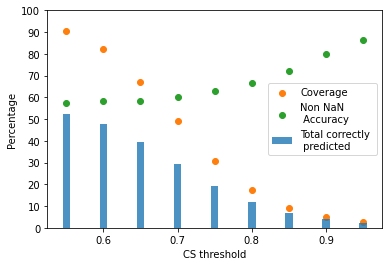

In [46]:
plot_comp(cov_MCF7_HL60,acc_MCF7_HL60)

In [48]:
RANGE_CS_THRESHOLDS = np.arange(0.55,0.96,0.05)
acc_MCF7_NTERA2, cov_MCF7_NTERA2 = run_overlap(CS_MCF7,test_NTERA2)

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


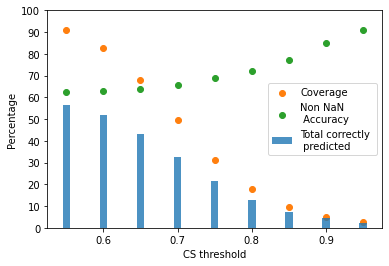

In [51]:
plot_comp(cov_MCF7_NTERA2,acc_MCF7_NTERA2)

In [16]:
RANGE_CS_THRESHOLDS = np.arange(0.55,0.96,0.05)
acc_NTERA2_HL60, cov_NTERA2_HL60 = run_overlap(CS_NTERA2,test_HL60,StandardErr_rawDataNTERA2)

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


[0.5760035  0.58179356 0.59334193 0.61554484 0.63630894 0.68919959
 0.74335033 0.81220062 0.8701014 ] [0.90749059 0.8151486  0.66560153 0.48283706 0.30521513 0.17242645
 0.09404591 0.05223245 0.02678749]


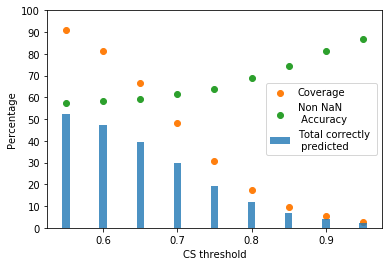

In [22]:
print(acc_NTERA2_HL60,cov_NTERA2_HL60)
plot_comp(cov_NTERA2_HL60,acc_NTERA2_HL60)

In [23]:
RANGE_CS_THRESHOLDS = np.arange(0.55,0.96,0.05)
acc_NTERA2_MCF7, cov_NTERA2_MCF7 = run_overlap(CS_NTERA2,test_MCF7,StandardErr_rawData)

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


[0.58433903 0.59603314 0.61524178 0.64288062 0.67657906 0.71824132
 0.77472611 0.83483653 0.90352874] [0.910859   0.82217526 0.67171511 0.48546868 0.3094925  0.17317415
 0.09487574 0.05123322 0.02548939]


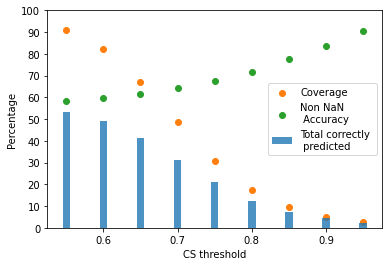

In [24]:
print(acc_NTERA2_MCF7,cov_NTERA2_MCF7)
plot_comp(cov_NTERA2_MCF7,acc_NTERA2_MCF7)

In [25]:
RANGE_CS_THRESHOLDS = np.arange(0.55,0.96,0.05)
acc_HL60_MCF7, cov_HL60_MCF7 = run_overlap(CS_HL60,test_MCF7,StandardErr_rawData)

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


[0.58066253 0.58388791 0.59943307 0.61609369 0.64307679 0.67166307
 0.69674217 0.73939929 0.82748049] [0.89105682 0.80966911 0.672912   0.50871697 0.33728464 0.20875437
 0.11731483 0.0575451  0.02604289]


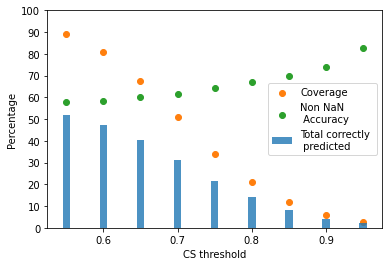

In [26]:
print(acc_HL60_MCF7,cov_HL60_MCF7)
plot_comp(cov_HL60_MCF7,acc_HL60_MCF7)

In [ ]:
CS_HL60[]

In [32]:
acc_HL60_NTERA2, cov_HL60_NTERA2 = run_overlap(CS_HL60,test_NTERA2,StandardErr_rawData)

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


[0.61975434 0.61926261 0.62795155 0.64372282 0.66925489 0.69800687
 0.7211138  0.76369083 0.84558623] [0.88928898 0.81168826 0.6747916  0.51103203 0.33646677 0.20851306
 0.11518725 0.05975682 0.02624018]


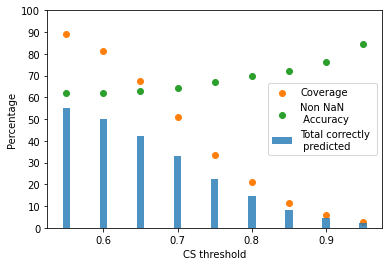

In [33]:
print(acc_HL60_NTERA2,cov_HL60_NTERA2)
plot_comp(cov_HL60_NTERA2,acc_HL60_NTERA2)

## random test 
See how model would do if its just fed random sites.

In [ ]:
#thres 0 is the number of clusters, thresh[1] is the number of sites in a cluster
threshold = (10000, 0.9955)

In [146]:
def Find_sim_sitesRand(CS_data,err_df,threshold):
    mask_clustNumb = np.random.choice(11320, threshold[0],replace=False)
    mask_clust_size = np.random.rand(threshold[0],11320 ) > threshold[1]
    dft = CS_MCF7.iloc[mask_clustNumb]
    for i in range(len(dft)):
        dft.iloc[i] = dft.iloc[i][mask_clust_size[i]]
    cos98temp = dft
    return cos98temp

In [147]:
def run_model_rand(CS_data_train,err_df,test_data,SE_rawData,threshold):
    cosSimX = Find_sim_sitesRand(CS_data_train,err_df,threshold)
    y_test,true_nonNan,true_nonNanErr = test(test_data,cosSimX,CS_data_train,SE_rawData)
    testR = [y_test,true_nonNan,true_nonNanErr]
    return testR

In [195]:
th_range = [(11320,1/11320)]

In [196]:
for threshold in th_range:
    print(threshold)
    testR = run_model_rand(CS_dataEfcMCF7,CS_errorEfc,test_dataMCF7,StandardErr_rawData,threshold)
    predicted_vals,true_vals,mean_coverage,acc = find_non_na_predicitons(testR)

(11320, 8.833922261484099e-05)
ave % of non nan predictions
1.0
0.5583305583305583
acc
------


In [157]:
mean_coverage,acc ,th_range

(1.0, 0.5629299878591664, [(11320, 0.0)])

In [154]:
mean_coverage,acc ,th_range

(0.8838762038368362, 0.5600462370474343, [(10000, 0.1)])

In [151]:
mean_coverage,acc ,th_range

(0.4465395151300265, 0.5604204601887105, [(5000, 0.1)])

In [139]:
mean_coverage,acc ,th_range

(0.3623923166889014, 0.5649763080955742, [(10000, 0.1)])

Shows the lower bound for the acc os 0.56 but just randomlly drawing from the current distrubtion. For all coverages up 0.36

In [162]:
Squahsed_round = np.round(squashed_data)

(array([168355.,      0.,      0.,      0.,      0., 395750.,      0.,
             0.,      0., 126415.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

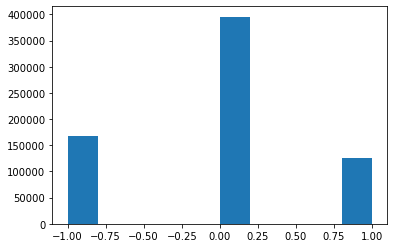

In [178]:
plt.hist(Squahsed_round.to_numpy().flatten() )